# PyTorch Face recognition

We can use PyTorch to recognize faces using the following models:
* VGG Face

In [91]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F
import torchvision.models as models

from PIL import Image, ImageFilter, ImageChops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_and_extract_archive

import requests
import copy
import os
import random
from io import BytesIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [92]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.imageutil import show_image

## VGG Face

### Download pretrained weights

In [93]:
#!wget  http://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz -P ./tmp/
#!tar -xvf ./tmp/vgg_face_torch.tar.gz -C ./tmp/

## Define network architecture

In [94]:
# we need the following lib to be able to load luatorch pretrained weights
!pip install torchfile

In [95]:
import torchfile

class VGG_16(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block_size = [2, 2, 3, 3, 3]
        self.conv_1_1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv_2_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv_3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_4_1 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.fc6 = nn.Linear(512 * 7 * 7, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 2622)

    def load_weights(self, path="./tmp/vgg_face_torch/VGG_FACE.t7"):
        model = torchfile.load(path)
        counter = 1
        block = 1
        for i, layer in enumerate(model.modules):
            if layer.weight is not None:
                if block <= 5:
                    self_layer = getattr(self, "conv_%d_%d" % (block, counter))
                    counter += 1
                    if counter > self.block_size[block - 1]:
                        counter = 1
                        block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]
                else:
                    self_layer = getattr(self, "fc%d" % (block))
                    block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]

    def forward(self, x):
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5, self.training)
        x = F.relu(self.fc7(x))
        x = F.dropout(x, 0.5, self.training)
        return self.fc8(x)

In [96]:
model = VGG_16().double()
model.load_weights()

## Evaluate

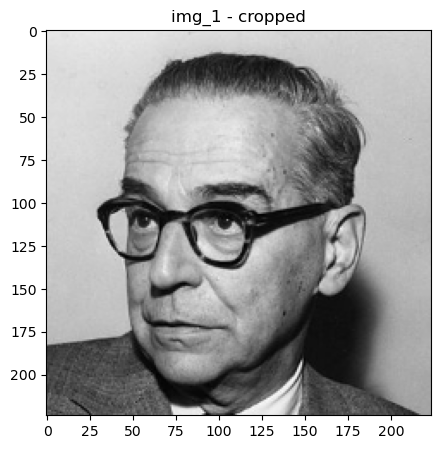

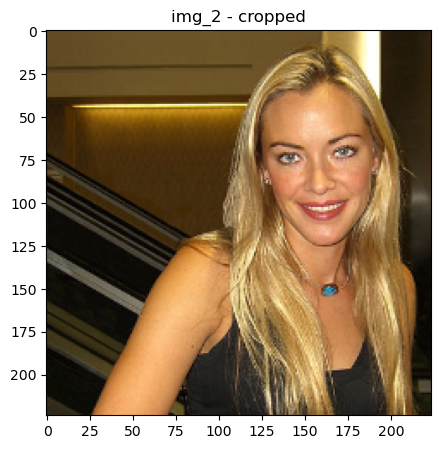

In [102]:
import cv2

img_1 = cv2.imread("./tmp/wiki/16/55016_1892-10-09_1961.jpg")
img_1 = cv2.resize(img_1, None, fx=0.7, fy=0.7)

img_1 = img_1[0:224, 55:279]
show_image(img_1, "img_1 - cropped")

img_2 = cv2.imread("./tmp/wiki/16/287316_1979-10-08_2011.jpg")
img_2 = cv2.resize(img_2, None, fx=0.6, fy=0.6)

img_2 = img_2[0:224, 0:224]
show_image(img_2, "img_2 - cropped")

img_1 = torch.Tensor(img_1).permute(2, 0, 1).view(1, 3, 224, 224).double()
img_2 = torch.Tensor(img_2).permute(2, 0, 1).view(1, 3, 224, 224).double()

In [117]:
from sklearn.metrics.pairwise import cosine_similarity

model.eval()

#img_1 -= torch.Tensor(np.array([129.1863, 104.7624, 93.5940])).double().view(1, 3, 1, 1)
#img_2 -= torch.Tensor(np.array([129.1863, 104.7624, 93.5940])).double().view(1, 3, 1, 1)

preds_1 = model(img_1).detach().numpy()
preds_2 = model(img_2).detach().numpy()

similarity = cosine_similarity(preds_1, preds_2)
print(similarity)

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

## Load Model
We can load a pretrained model from here:
https://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pt

In [119]:

!wget https://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth -P ./tmp/

--2023-08-04 13:38:20--  https://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2, 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580015466 (553M)
Saving to: ‘./tmp/vgg_face_dag.pth.1’

vgg_face_dag.pth.1  100%[===================>] 553.15M  8.87MB/s    in 55s     

2023-08-04 13:39:15 (9.98 MB/s) - ‘./tmp/vgg_face_dag.pth.1’ saved [580015466/580015466]



In [121]:
model = torch.load('./tmp/vgg_face_dag.pth')
print(model)

OrderedDict([('conv1_1.weight', tensor([[[[ 0.0646,  0.0362, -0.0239],
          [ 0.1454,  0.1175,  0.0476],
          [ 0.1501,  0.1336,  0.0714]],

         [[ 0.0722,  0.0398, -0.0259],
          [ 0.1553,  0.1277,  0.0516],
          [ 0.1723,  0.1514,  0.0800]],

         [[ 0.0242, -0.0037, -0.0587],
          [ 0.0911,  0.0672,  0.0009],
          [ 0.1022,  0.0893,  0.0265]]],


        [[[-0.1384, -0.1477, -0.1685],
          [-0.1409, -0.1545, -0.1780],
          [-0.1530, -0.1629, -0.1784]],

         [[ 0.1663,  0.1563,  0.1339],
          [ 0.1695,  0.1593,  0.1329],
          [ 0.1513,  0.1420,  0.1193]],

         [[ 0.0532,  0.0486,  0.0227],
          [ 0.0653,  0.0584,  0.0286],
          [ 0.0449,  0.0385,  0.0150]]],


        [[[ 0.0072,  0.0097,  0.0003],
          [ 0.0584,  0.0642,  0.0525],
          [ 0.0799,  0.0937,  0.0791]],

         [[-0.0018, -0.0003, -0.0058],
          [ 0.0533,  0.0601,  0.0478],
          [ 0.0801,  0.0928,  0.0795]],

         [[-

In [115]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [112]:
import numpy as np

def get_face_descriptors(images):
    batch_size = images.size(0)
    features = np.zeros((batch_size, 4096))

    for i in range(batch_size):
        image = images[i]
        image = transform(image)
        image = image.unsqueeze(0)
        with torch.no_grad():
            feature = model(image)
        feature = feature.squeeze()
        feature = feature.cpu().numpy()
        features[i] = feature

    return features

In [ ]:
img_1 = cv2.imread("./tmp/wiki/16/55016_1892-10-09_1961.jpg")
img_1 = cv2.resize(img_1, None, fx=0.7, fy=0.7)

img_1 = img_1[0:224, 55:279]
show_image(img_1, "img_1 - cropped")

img_2 = cv2.imread("./tmp/wiki/16/287316_1979-10-08_2011.jpg")
img_2 = cv2.resize(img_2, None, fx=0.6, fy=0.6)

img_2 = img_2[0:224, 0:224]
show_image(img_2, "img_2 - cropped")

img_1 = torch.Tensor(img_1).permute(2, 0, 1).view(1, 3, 224, 224).double()
img_2 = torch.Tensor(img_2).permute(2, 0, 1).view(1, 3, 224, 224).double()

In [116]:
img_1 = cv2.imread("./tmp/wiki/16/55016_1892-10-09_1961.jpg")
img_1 = cv2.resize(img_1, None, fx=0.7, fy=0.7)

img_1 = img_1[0:224, 55:279]

image = transform(img_1)
image = image.unsqueeze(0)

print(image)
with torch.no_grad():
    feature = model(image)
feature = feature.squeeze()
feature = feature.cpu().numpy()
print(feature)

tensor([[[[ 0.8118,  0.8196,  0.8039,  ...,  0.6314,  0.6392,  0.6392],
          [ 0.8196,  0.8196,  0.8118,  ...,  0.6314,  0.6314,  0.6314],
          [ 0.8196,  0.8196,  0.8196,  ...,  0.6314,  0.6235,  0.6235],
          ...,
          [-0.3020, -0.1765, -0.0902,  ...,  0.3020,  0.2941,  0.2784],
          [-0.2235, -0.3490, -0.2706,  ...,  0.2941,  0.2784,  0.2627],
          [-0.2235, -0.1529, -0.3020,  ...,  0.2863,  0.2627,  0.2706]],

         [[ 0.8118,  0.8196,  0.8039,  ...,  0.6314,  0.6392,  0.6392],
          [ 0.8196,  0.8196,  0.8118,  ...,  0.6314,  0.6314,  0.6314],
          [ 0.8196,  0.8196,  0.8196,  ...,  0.6314,  0.6235,  0.6235],
          ...,
          [-0.3020, -0.1765, -0.0902,  ...,  0.3020,  0.2941,  0.2784],
          [-0.2235, -0.3490, -0.2706,  ...,  0.2941,  0.2784,  0.2627],
          [-0.2235, -0.1529, -0.3020,  ...,  0.2863,  0.2627,  0.2706]],

         [[ 0.8118,  0.8196,  0.8039,  ...,  0.6314,  0.6392,  0.6392],
          [ 0.8196,  0.8196,  

TypeError: 'collections.OrderedDict' object is not callable